# Procesamiento natural del lenguaje
## Carrear de especializacion en inteligencia artificial

# Desafío 1

**Alumno:**

**Nahuel Otonelo Canale**

### Enunciado:

> **Cada experimento realizado debe estar acompañado de una explicación o interpretación de lo observado.**
> 
> **1**. Vectorizar documentos. Tomar 5 documentos al azar y medir similaridad con el resto de los documentos.
> Estudiar los 5 documentos más similares de cada uno analizar si tiene sentido
> la similaridad según el contenido del texto y la etiqueta de clasificación.
> 
> **2**. Construir un modelo de clasificación por prototipos (tipo zero-shot). Clasificar los documentos de un conjunto de test comparando cada uno con todos los de entrenamiento y asignar la clase al label del documento del conjunto de entrenamiento con mayor similaridad.
> 
> **3**. Entrenar modelos de clasificación Naïve Bayes para maximizar el desempeño de clasificación
> (f1-score macro) en el conjunto de datos de test. Considerar cambiar parámteros
> de instanciación del vectorizador y los modelos y probar modelos de Naïve Bayes Multinomial
> y ComplementNB.
> 
> **NO cambiar el hiperparámetro ngram_range de los vectorizadores**.
> 
> **4**. Transponer la matriz documento-término. De esa manera se obtiene una matriz
> término-documento que puede ser interpretada como una colección de vectorización de palabras.
> Estudiar ahora similaridad entre palabras tomando 5 palabras y estudiando sus 5 más similares.
> 
> **Elegir las palabras MANUALMENTE para evitar la aparición de términos poco interpretables**.

In [36]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


from sklearn.datasets import fetch_20newsgroups
import numpy as np
import pandas as pd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# 1
___

### Analizar datos de train solamente para evitar el data lackage

In [37]:
# se cargan los datos (ya separados de forma predeterminada en train y test)
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

### Vectorizar documentos

In [38]:


# usamos stop_words='english' para eliminar las palabras vacías en inglés (como "the", "is", "and", etc.)
tfidfvect = TfidfVectorizer(stop_words='english')

X_train = tfidfvect.fit_transform(newsgroups_train.data)


In [39]:
X_train.shape

(11314, 101322)

In [40]:
# Tomar 5 índices aleatorios de los documentos en X_train
num_documentos = X_train.shape[0]

np.random.seed(42)  # Para reproducibilidad

# (se usa replace=False para asegurarnos de que no se repitan)
indices_aleatorios = np.random.choice(num_documentos, 5, replace=False)



# Obtener las etiquetas
y_train = newsgroups_train.target

# Para cada índice aleatorio, realizar el análisis solicitado
for idx in indices_aleatorios:
    print(f"\n--- ANÁLISIS DEL DOCUMENTO ÍNDICE: {idx} ---")

    # Imprimimos el texto original
    print(f"CLASE REAL: {newsgroups_train.target_names[y_train[idx]]}")
    #print("TEXTO ORIGINAL:")
    #print(newsgroups_train.data[idx][:500] + "...") # Imprimimos solo los primeros 500 caracteres

    # Medimos similaridad 
    cossim = cosine_similarity(X_train[idx], X_train)[0]

    # Obtenemos los 5 más similares (como en la celda [17])
    # [1:6] porque el [0] es el documento mismo (similaridad = 1.0)
    mostsim = np.argsort(cossim)[::-1][1:6]

    # 6. Imprimimos los resultados (como en la celda [19])
    print("\nCLASES DE LOS 5 MÁS SIMILARES:")
    for i in mostsim:
        print(f"  -> Índice {i}: {newsgroups_train.target_names[y_train[i]]}, Similaridad: {cossim[i]:.4f}")

    print("-------------------------------------------------")



--- ANÁLISIS DEL DOCUMENTO ÍNDICE: 7492 ---
CLASE REAL: comp.sys.mac.hardware

CLASES DE LOS 5 MÁS SIMILARES:
  -> Índice 10935: comp.sys.mac.hardware, Similaridad: 0.7025
  -> Índice 7258: comp.sys.ibm.pc.hardware, Similaridad: 0.3700
  -> Índice 4971: comp.sys.mac.hardware, Similaridad: 0.1519
  -> Índice 4303: misc.forsale, Similaridad: 0.1473
  -> Índice 3580: alt.atheism, Similaridad: 0.1359
-------------------------------------------------

--- ANÁLISIS DEL DOCUMENTO ÍNDICE: 3546 ---
CLASE REAL: comp.os.ms-windows.misc

CLASES DE LOS 5 MÁS SIMILARES:
  -> Índice 5665: comp.sys.ibm.pc.hardware, Similaridad: 0.1996
  -> Índice 2011: comp.sys.ibm.pc.hardware, Similaridad: 0.1899
  -> Índice 8765: comp.sys.ibm.pc.hardware, Similaridad: 0.1702
  -> Índice 8643: comp.sys.ibm.pc.hardware, Similaridad: 0.1670
  -> Índice 1546: comp.sys.ibm.pc.hardware, Similaridad: 0.1416
-------------------------------------------------

--- ANÁLISIS DEL DOCUMENTO ÍNDICE: 5582 ---
CLASE REAL: misc.fors

### Análisis de resultados:




En general podría decirse que para estos casos, hay mayor indice de similaridad para textos referidos a la misma clase.

Para el segundo caso por ejemplo, si bien no coincide la clase, la temática es bastante similar :CLASE REAL: comp.os.ms-windows.misc y los 5 mas similares son comp.sys.ibm.pc.hardware. También se observan esas similaridades para los otros ejemplos.

Una cosa a chequear es si las clases estan balanceadas.


### Gráfico de balanceo de clases

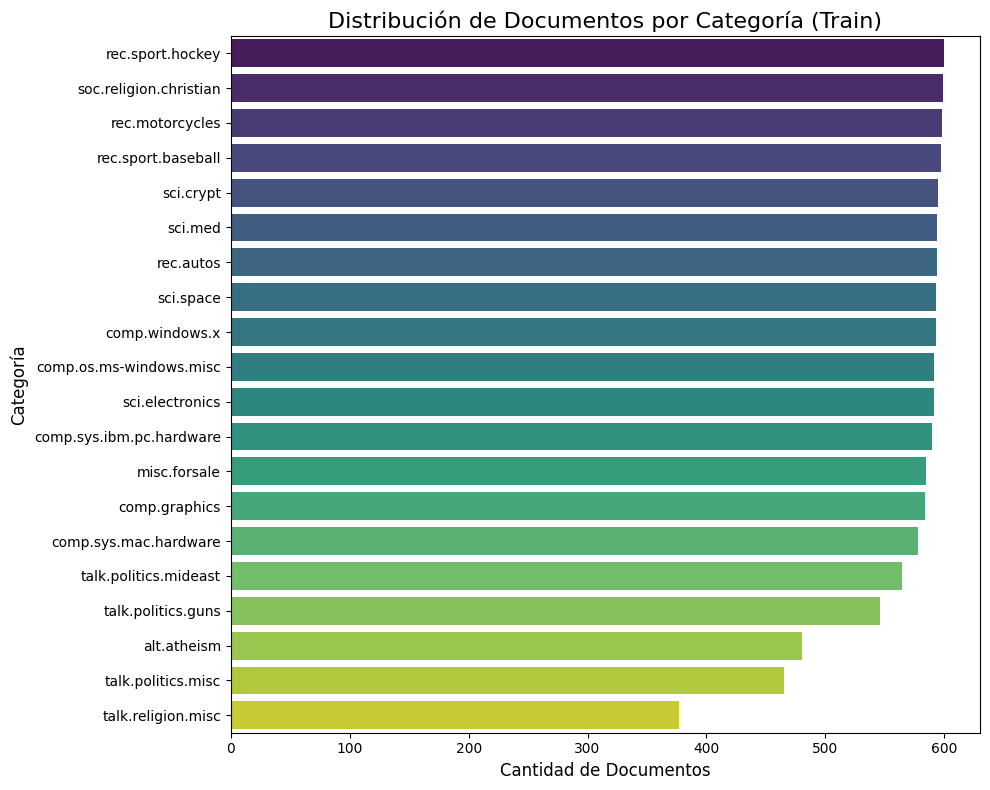

<Figure size 640x480 with 0 Axes>

In [41]:
# Obtener las etiquetas (targets) y los nombres de las categorías
y_train = newsgroups_train.target
target_names = newsgroups_train.target_names

# Convertir los números de las etiquetas (0, 1, 2...) a sus nombres reales
y_train_names = [target_names[i] for i in y_train]

# Usar Pandas para contar
class_series = pd.Series(y_train_names)
class_counts = class_series.value_counts() # .value_counts() ya ordena de mayor a menor

# --- Crear el gráfico ---


plt.figure(figsize=(10, 8))

# Crear el gráfico de barras horizontal
# Usamos class_counts.index para el eje Y (categorías)
# Usamos class_counts.values para el eje X (conteos)
sns.barplot(x=class_counts.values, y=class_counts.index, palette='viridis', hue=class_counts.index, legend=False)

plt.title('Distribución de Documentos por Categoría (Train)', fontsize=16)
plt.xlabel('Cantidad de Documentos', fontsize=12)
plt.ylabel('Categoría', fontsize=12)

# Asegurar que las etiquetas no se corten
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# También puedes guardar la imagen si lo deseas (descomenta la siguiente línea)
plt.savefig('distribucion_clases.png')

Las primeras 10 o 15 clases todas tienen el mismo numero de elementos, practicamente no hay diferencia. las clases talk.religion.misc, talk.politics.misc y alt.atheism tienen entre un 21 y 35 % menos de elementos.

# 2
___

La idea del algoritmo planteado en el ejercicio 2 es asignarle la clase a un texto que no se la conocemos. Para eso, le asignamos la clase del que tiene mayor similaridad coseno proveniente de la matriz de train.

In [42]:
# Creamos la matriz TF-IDF para el conjunto de prueba
X_test = tfidfvect.transform(newsgroups_test.data)
y_test = newsgroups_test.target

print(X_test.shape, y_test.shape)

(7532, 101322) (7532,)


In [43]:
# Calculamos la matriz de similaridad coseno entre X_test y X_train
sim_matrix = cosine_similarity(X_test, X_train)

# np.argmax(axis=1) nos da el ÍNDICE (la columna) del valor máximo
# para cada fila (axis=1).
# El resultado es un array de shape (7532,)
indices_mas_cercanos = np.argmax(sim_matrix, axis=1)

# Esta es la predicción final
# Es un truco de "fancy indexing" de Numpy
y_pred = y_train[indices_mas_cercanos]



In [44]:

score = f1_score(y_test, y_pred, average='macro')
print(f"F1-Score del modelo 'Prototipo' (k-NN=1): {score:.4f}")

F1-Score del modelo 'Prototipo' (k-NN=1): 0.5327


Como el modelo 1-NN (que solo mira al vecino más cercano) podía ser inestable, se me ocurrió probar un **k-NN** para que la clase se decida por una **votación de $k$ vecinos**.

Para encontrar el mejor $k$, probé un rango de 1 a 21 y comparé dos métodos de votación:

1.  **Voto Democrático (`weights='uniform'`):** Un voto por mayoría simple. Todos los $k$ vecinos valen lo mismo.
2.  **Voto Calificado (`weights='distance'`):** Los vecinos más cercanos (más similares) tienen un voto "más fuerte".

El gráfico muestra las dos curvas (un método contra el otro) para encontrar qué $k$ y qué método de votación nos da el mejor F1-Score.

Iniciando búsqueda de hiperparámetro 'k' para k-NN...
--- Probando con k = 1 ---
  F1 (uniform): 0.5310
  F1 (distance): 0.5310
--- Probando con k = 2 ---
  F1 (uniform): 0.5025
  F1 (distance): 0.5308
--- Probando con k = 3 ---
  F1 (uniform): 0.5386
  F1 (distance): 0.5609
--- Probando con k = 4 ---
  F1 (uniform): 0.5532
  F1 (distance): 0.5688
--- Probando con k = 5 ---
  F1 (uniform): 0.5651
  F1 (distance): 0.5787
--- Probando con k = 6 ---
  F1 (uniform): 0.5720
  F1 (distance): 0.5900
--- Probando con k = 7 ---
  F1 (uniform): 0.5801
  F1 (distance): 0.5952
--- Probando con k = 8 ---
  F1 (uniform): 0.5845
  F1 (distance): 0.6019
--- Probando con k = 9 ---
  F1 (uniform): 0.5914
  F1 (distance): 0.6036
--- Probando con k = 10 ---
  F1 (uniform): 0.5946
  F1 (distance): 0.6100
--- Probando con k = 11 ---
  F1 (uniform): 0.5982
  F1 (distance): 0.6105
--- Probando con k = 12 ---
  F1 (uniform): 0.6024
  F1 (distance): 0.6147
--- Probando con k = 13 ---
  F1 (uniform): 0.6023
  F1

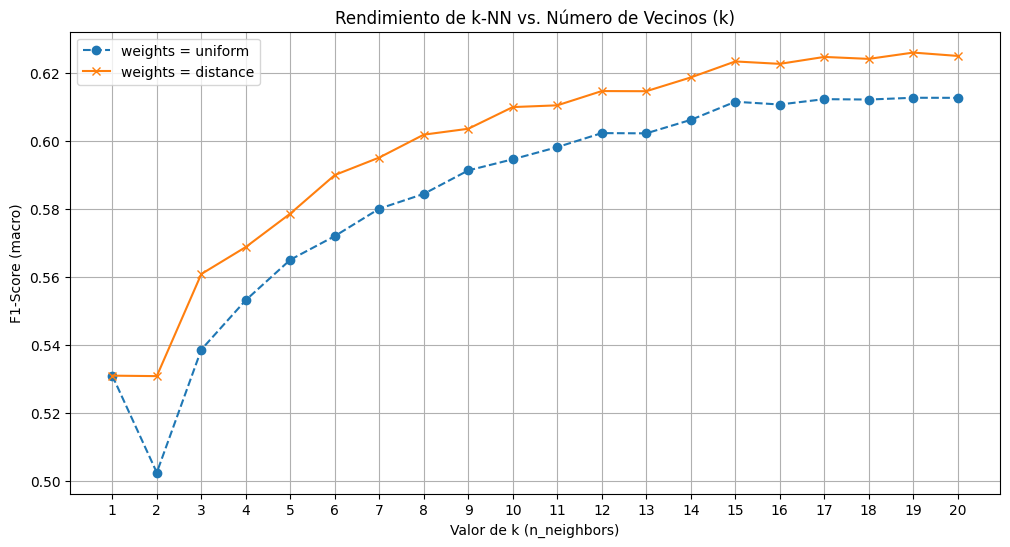

In [45]:
# 1. Definimos el rango de 'k' que queremos probar
k_values = range(1, 21) # Va de 1 a 20

# 2. Listas para guardar los scores de cada 'k'
f1_scores_uniform = []
f1_scores_distance = []

print("Iniciando búsqueda de hiperparámetro 'k' para k-NN...")

# 3. El 'for' loop que pediste
for k in k_values:
    print(f"--- Probando con k = {k} ---")

    # --- Modelo con 'weights=uniform' (voto simple) ---
    knn_uni = KNeighborsClassifier(n_neighbors=k, metric='cosine', weights='uniform')
    knn_uni.fit(X_train, y_train)
    y_pred_uni = knn_uni.predict(X_test)
    score_uni = f1_score(y_test, y_pred_uni, average='macro')
    f1_scores_uniform.append(score_uni)
    print(f"  F1 (uniform): {score_uni:.4f}")

    # --- Modelo con 'weights=distance' (voto ponderado) ---
    knn_dist = KNeighborsClassifier(n_neighbors=k, metric='cosine', weights='distance')
    knn_dist.fit(X_train, y_train)
    y_pred_dist = knn_dist.predict(X_test)
    score_dist = f1_score(y_test, y_pred_dist, average='macro')
    f1_scores_distance.append(score_dist)
    print(f"  F1 (distance): {score_dist:.4f}")

print("¡Búsqueda terminada!")

# 4. Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(k_values, f1_scores_uniform, marker='o', linestyle='--', label='weights = uniform')
plt.plot(k_values, f1_scores_distance, marker='x', linestyle='-', label='weights = distance')
plt.title('Rendimiento de k-NN vs. Número de Vecinos (k)')
plt.xlabel('Valor de k (n_neighbors)')
plt.ylabel('F1-Score (macro)')
plt.xticks(k_values) # Asegura que se muestren todos los números de 'k' en el eje X
plt.legend()
plt.grid(True)
plt.show()

El F1 Score se satura para valores de k mayores a 15.

El mejor desempeño de F1 score se da para weights=distance, y creo que era de esperarse.

# 3
___

In [46]:

clf_multi = MultinomialNB()
clf_multi.fit(X_train, y_train)
y_pred_multi = clf_multi.predict(X_test)

score = f1_score(y_test, y_pred_multi, average='macro')
print(f"F1 (con StopWords): {score:.4f}")

F1 (con StopWords): 0.6468


In [47]:
clf_comp = ComplementNB() # <- ¡El cambio!
clf_comp.fit(X_train, y_train)
y_pred_comp = clf_comp.predict(X_test)

score_comp = f1_score(y_test, y_pred_comp, average='macro')
print(f"F1 (con StopWords + ComplementNB): {score_comp:.4f}")

F1 (con StopWords + ComplementNB): 0.6936


En los pasos anteriores,identificamos que complementDB daba mejor F1 score que MultinomialNB. Ahora probamos modificando los parámetros tfidf__min_df y tfidf__max_df de TfidfVectorizer y clf__alpha de ComplementNB, utilizando grid search. 

In [48]:


# Encadenamos el vectorizador y el clasificador


pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')), # stop_words queda fijo
    ('clf', ComplementNB())                           # El clasificador que se eligió
])

# --- Definir el "Grid" de Parámetros ---
# Este es el diccionario con lo que quieres probar.



param_grid_relativo = {
    # Probar "sin filtro", "filtrar 0.5%" y "filtrar 1%"
    'tfidf__min_df': [1, 0.005, 0.01], 
    
    # Probar "sin filtro", "filtrar 97%" y "filtrar 95%"
    'tfidf__max_df': [1.0, 0.97, 0.95],
    
    'clf__alpha': [0.1, 0.5, 1.0]
}


# (No se toca ngram_range, como se pidió)

# --- Paso 3: Instanciar GridSearchCV ---
#   estimator=pipe         -> El pipeline que se tunea
#   param_grid=param_grid  -> El grid que se define
#   scoring='f1_macro'     -> La métrica que se va a maximizar
#   cv=3                   -> 3-Fold Cross-Validation 
#   n_jobs=-1              -> Usa todos los núcleos de la CPU para hacerlo en paralelo

print("Iniciando GridSearchCV... Esto puede tardar varios minutos.")
grid_search = GridSearchCV(estimator=pipe, 
                           param_grid=param_grid_relativo, 
                           scoring='f1_macro', 
                           cv=3, 
                           n_jobs=-1)

# --- Ejecutar la Búsqueda ---
# .fit() ahora hace TODO:
# 1. Divide train en 3 (CV)
# 2. Prueba TODAS las combinaciones de parámetros (3*3*3 = 27 combinaciones)
# 3. Lo hace 3 veces (por el CV), así que entrena 81 modelos.
# 4. Encuentra la mejor combinación
grid_search.fit(newsgroups_train.data, y_train)

# --- Ver los Resultados ---
print("\n¡Búsqueda completada!")
print(f"Mejor F1-score (macro) encontrado en Cross-Validation: {grid_search.best_score_:.4f}")
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

# --- Evaluar en el Conjunto de Test ---
# 'grid_search' es ahora un objeto que *ya está entrenado* con los mejores parámetros
# usando TODOS los datos de train.
# Ahora lo usamos para predecir en 'test'.
print("\nEvaluando el mejor modelo en el conjunto de Test...")
best_model = grid_search.best_estimator_ # Este es el pipeline ya re-entrenado
y_pred_final = best_model.predict(newsgroups_test.data)

final_f1_score = f1_score(y_test, y_pred_final, average='macro')
print(f"F1-Score final en Test: {final_f1_score:.4f}")

Iniciando GridSearchCV... Esto puede tardar varios minutos.

¡Búsqueda completada!
Mejor F1-score (macro) encontrado en Cross-Validation: 0.7551
Mejores parámetros encontrados:
{'clf__alpha': 0.5, 'tfidf__max_df': 1.0, 'tfidf__min_df': 1}

Evaluando el mejor modelo en el conjunto de Test...
F1-Score final en Test: 0.6978


Con la búsqueda de hiperparametros la verdad que no se mejoró mucho el resultado respecto al caso anterior, con solo con StopWords + ComplementNB. De hecho, los parametros que mejor F1  tuvieron fueron los mismos que en el caso anterior: 'tfidf__max_df': 1.0 y 'tfidf__min_df': 1.


# 4
___

In [49]:

idx2word = {v: k for k,v in tfidfvect.vocabulary_.items()}


# Definir las palabras a estudiar ---

palabras_a_estudiar = ['computer', 'car', 'god', 'baseball', 'president']

# --- Transponer la matriz ---

# X_train es (documentos, palabras)
X_train_T = X_train.T 
# X_train_T es ahora (palabras, documentos)

# --- Optimización de formato (de CSC a CSR) ---
# Esto hace que las búsquedas por FILA (por palabra) sean instantáneas
X_train_T_csr = X_train_T.tocsr()
print("Optimización de matriz completada.")


# --- Bucle principal de análisis ---
for palabra in palabras_a_estudiar:
    print(f"\n--- PALABRA OBJETIVO: '{palabra}' ---")
    
    try:
        # Encontrar la palabra en el vocabulario ---
        # Usamos el vocabulario para obtener el ÍNDICE de la palabra
        idx = tfidfvect.vocabulary_[palabra]

        # --- Obtener el vector de la palabra ---
        # Pedimos la FILA 'idx' de nuestra matriz transpuesta (que es el vector de la palabra)
        vec_palabra = X_train_T_csr[idx]

        # --- Calcular similaridad coseno ---
        # Comparamos el vector de nuestra palabra contra TODOS los otros vectores de palabras
        cossim = cosine_similarity(vec_palabra, X_train_T_csr)[0]

        # --- Obtener las 5 más similares ---
        # Usamos argsort para obtener los índices, y [::-1] para invertir el orden
        # Empezamos en [1] porque [0] siempre será la palabra misma (similaridad 1.0)
        mostsim_idx = np.argsort(cossim)[::-1][1:6]

        # --- Mostrar resultados ---
        print(f"Palabras más similares a '{palabra}':")
        for i in mostsim_idx:
            # Usamos 'idx2word' para convertir el índice (ej. 25775) de nuevo a una palabra (ej. 'car')
            print(f"  -> {idx2word[i]} (Similaridad: {cossim[i]:.4f})")

    except KeyError:
        # Esto pasa si la palabra (ej. 'president') no estaba en el vocabulario
        # Pudo ser filtrada por stop_words o min_df si usaste un vectorizador diferente
        print(f"** La palabra '{palabra}' no se encontró en el vocabulario. **")
    
    print("-" * 40)

Optimización de matriz completada.

--- PALABRA OBJETIVO: 'computer' ---
Palabras más similares a 'computer':
  -> decwriter (Similaridad: 0.1579)
  -> harkens (Similaridad: 0.1531)
  -> deluged (Similaridad: 0.1531)
  -> shopper (Similaridad: 0.1421)
  -> delicate (Similaridad: 0.1366)
----------------------------------------

--- PALABRA OBJETIVO: 'car' ---
Palabras más similares a 'car':
  -> cars (Similaridad: 0.1898)
  -> criterium (Similaridad: 0.1732)
  -> dealer (Similaridad: 0.1732)
  -> civic (Similaridad: 0.1713)
  -> owner (Similaridad: 0.1644)
----------------------------------------

--- PALABRA OBJETIVO: 'god' ---
Palabras más similares a 'god':
  -> jesus (Similaridad: 0.2806)
  -> bible (Similaridad: 0.2764)
  -> christ (Similaridad: 0.2668)
  -> faith (Similaridad: 0.2593)
  -> existence (Similaridad: 0.2589)
----------------------------------------

--- PALABRA OBJETIVO: 'baseball' ---
Palabras más similares a 'baseball':
  -> tommorrow (Similaridad: 0.1820)
  -> foo


El método funciona muy bien para palabras que a priori uno pensaría que pueden ser identificadas con ciertas categorias:

- 'god': Los resultados (jesus, bible, christ, faith). Todas son palabras del mismo dominio (soc.religion.christian, alt.atheism). 

- 'car': Los resultados (cars, dealer, civic, owner) también son muy fuertes. Capturan el plural, roles asociados (dueño, vendedor) y un modelo específico (Honda Civic).

El método se vuelve menos confiable cuando la palabra objetivo es demasiado genérica o cuando los resultados más similares son ruido estadístico.

- 'computer' (Computadora): Los resultados (decwriter, harkens, deluged) son incomprensibles. La palabra "computer" es tan genérica en este dataset (aparece en comp.graphics, comp.sys.mac, comp.windows, sci.electronics, misc.forsale, etc.) que su "vector de contexto" es muy "borroso" y no apunta a una dirección clara.

- 'baseball' (Béisbol): Este es un caso mixto. football (fútbol) es un resultado semántico perfecto (otro deporte). Sin embargo, tommorrow (un error de tipeo) y lubchansky, penna (probablemente nombres de usuarios o jugadores mencionados una sola vez) son ruido.

Hallazgo Más Interesante: Co-ocurrencia Tópica vs. Sinonimia

Los resultados de 'president' son quizás los más interesantes.

- secretary 
- oval (oval, por "Oficina Oval") 
  
son aciertos semánticos.

- _________________________________ es un artefacto de formato, ruido puro.

*Dato de color:*

- miyazawa (0.3932): Kiichi Miyazawa era el Primer Ministro de Japón en la época de este dataset (principios de los 90). El modelo no aprendió un sinónimo de "presidente", sino una co-ocurrencia tópica: en los documentos donde se habla de "presidente" (en los foros de talk.politics), también se habla mucho de "Miyazawa".

En conclusión: Este método simple de vectorización de palabras no entiende el lenguaje como un humano, pero es muy poderoso para encontrar palabras que se usan en contextos similares. Falla cuando el contexto es demasiado amplio (genérico) o cuando es contaminado por ruido (nombres raros, errores de tipeo).